In [4]:
from remote_vgk import *
from buffet import (
    buffet_classification
)

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

def load_password(path):

    with open(path) as f:
        secrets = json.load(f)
        shifted_pwd = secrets['password']
    pwd = ''
    for s in shifted_pwd:
        pwd += chr(ord(s) - 1)

    return pwd

In [5]:
try:
    window = gw.getWindowsWithTitle("RealVNC")[0]
except IndexError:
    raise Exception("Window not found")

pwd = load_password('secrets.json')
sesh = DPO_Session('lwp26', pwd)

App = AirfoilApp(sesh.teaching_client, window, "2.3_incidence_aerofoil")

# IMPORTANT SET THE SAME PARAMETERS AS ON THE APP
App.alpha = 1.75
App.M = 0.76
App.Re = 10

0.64656 0.00995


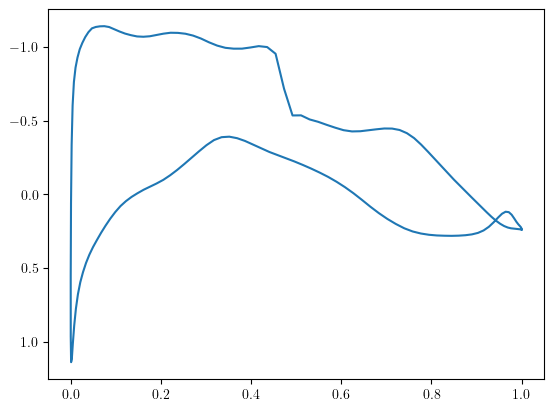

In [6]:

res = App.run(0.75, 2.3, 10)

plt.plot(res.x, res.cp)

print(res.Cl, res.Cd)

# flip y axis
plt.gca().invert_yaxis()


In [7]:
def compute_path_length(x, z):
    dx = np.diff(x)
    dz = np.diff(z)
    ds = np.sqrt(dx**2 + dz**2)
    return np.concatenate(([0], np.cumsum(ds)))

def compute_curvature(x, z):
    dx = np.gradient(x)
    dz = np.gradient(z)
    ddx = np.gradient(dx)
    ddz = np.gradient(dz)
    curvature = np.abs(ddx * dz - dx * ddz) / (dx**2 + dz**2)**1.5
    return curvature

0.64656 0.00995 0.0013500000000000005


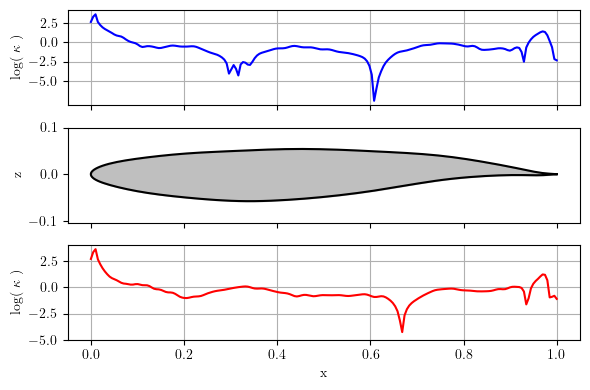

In [8]:
print(res.Cl, res.Cd, res.CD2)
from scipy import interpolate
from matplotlib.gridspec import GridSpec
idx_chord_eq_1 = 1 + np.argmin(np.abs(res.x[1:]))

upper_surface_z = res.z[idx_chord_eq_1:]
lower_surface_z = res.z[:idx_chord_eq_1]
upper_surface_x = res.x[idx_chord_eq_1:]
lower_surface_x = res.x[:idx_chord_eq_1]

# interp surfaces to same x values
interp_upper_x = np.linspace(upper_surface_x.min(), upper_surface_x.max(), 200)
interp_upper_z = interpolate.interp1d(upper_surface_x, upper_surface_z, kind='cubic')(interp_upper_x)

interp_lower_x = np.linspace(lower_surface_x.min(), lower_surface_x.max(), 200)
interp_lower_z = interpolate.interp1d(lower_surface_x, lower_surface_z, kind='cubic')(interp_lower_x)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 4))
gs = GridSpec(3, 1, height_ratios=[1.5, 1, 1.5], hspace=0.1)


# curvature plot
upper_path_length = compute_path_length(interp_upper_x, interp_upper_z)
lower_path_length = compute_path_length(interp_lower_x, interp_lower_z)
upper_curvature = compute_curvature(interp_upper_x, interp_upper_z)
lower_curvature = compute_curvature(interp_lower_x, interp_lower_z)

axes[0].plot(interp_upper_x, np.log(upper_curvature), label='Upper Surface', color='blue')
axes[0].grid()
axes[1].fill_between(interp_upper_x, 
                 interp_upper_z, 
                 interp_lower_z, 
                 color='gray', alpha=0.5)
axes[1].plot(res.x, res.z, 'k')

axes[1].axis('equal')
axes[2].plot(interp_lower_x, np.log(lower_curvature), label='Lower Surface', color='red')
axes[2].grid()

axes[2].set_xlabel('x')
axes[0].set_ylabel('log( $\\kappa$ )')
axes[0].set_yticks(np.arange(-5, 5, 2.5))
axes[1].set_ylabel('z')
axes[2].set_ylabel('log( $\\kappa$ )')
axes[2].set_yticks(np.arange(-5, 5, 2.5))

plt.tight_layout()
plt.savefig('figures/airfoil.png', dpi=300)
plt.show()

In [9]:

#App.classify_buffeting()

C:\Users\louis\AppData\Local\Temp\ipykernel_36668\3016680403.py:56: UserWarning: No contour levels were found within the data range.
  ax.contour(x_grid, y_grid, z_grid_smoothed, levels=[lvls[nt]], colors='black', linewidths=1, zorder = 20)


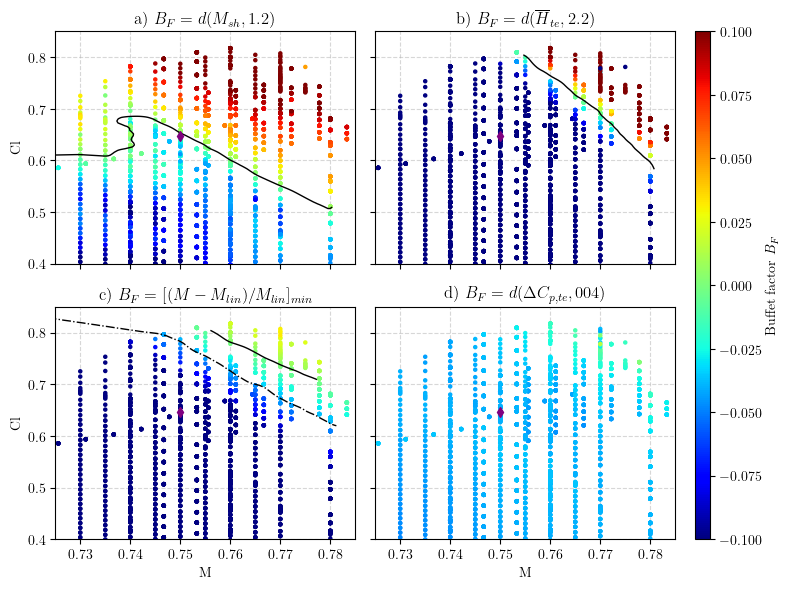

In [10]:
from matplotlib import gridspec
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# scatter plot
buffet_types = [
    'a) $B_F = d(M_{sh}, 1.2)$',
    'b) $B_F = d(\overline{H}_{te}, 2.2)$',
    'c) $B_F = [(M - M_{lin})/M_{lin}]_{min}$',
    'd) $B_F = d(\Delta C_{p,te}, 004)$'
]

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.05])
# Create subplots with shared axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax1)
colax = fig.add_subplot(gs[:2, 2:])  # For the colorbar

axes = [ax1, ax2, ax3, ax4]

lvls = [0, 0, 0, 0]

for nt,type in enumerate(buffet_types):

    ax = axes[nt]

    Cl_list = []
    M_list = []
    alpha_list = []

    for res in App:
        
        Cl_list.append(res.Cl)
        M_list.append(res.M)
        alpha_list.append(res.alpha)

    buffeting_list = np.nan*np.ones(len(Cl_list))
    i = 0
    for res in App:
        if len(res.buffet_causes) > 0:
            buffeting_list[i] = res.buffet_causes[nt]
        i += 1

    x_grid, y_grid = np.meshgrid(
        np.linspace(np.min(M_list), np.max(M_list), 200),
        np.linspace(np.min(Cl_list), np.max(Cl_list), 200)
        )

    z_grid = griddata((M_list, Cl_list), buffeting_list, (x_grid, y_grid), method='linear')
    z_grid_smoothed = gaussian_filter(z_grid, sigma=1) 

    scat = ax.scatter(M_list, Cl_list, c=buffeting_list, s = 5, cmap='jet', vmin=-0.1, vmax=0.1, zorder = 10)
    ax.contour(x_grid, y_grid, z_grid_smoothed, levels=[lvls[nt]], colors='black', linewidths=1, zorder = 20)
    if type[0] == 'c':
        ax.contour(x_grid, y_grid, z_grid_smoothed, levels=[-0.042], colors='black', linewidths=1, linestyles='dashdot', zorder = 20)
    # plot operating point as big purple diamond
    ax.plot(0.75, 0.64656, 'd', color='purple', markersize=5, zorder = 30)
    ax.set_xlim(0.725, 0.785)
    ax.set_ylim(0.4, 0.85)
    # create colourbar
    ax.grid( linestyle='--', alpha=0.5, zorder=1)
    ax.set_title(f'{type}')

for ax in [ax2, ax4]:  # Hide y-axis labels for the right column
    ax.tick_params(labelleft=False)
for ax in [ax1, ax2]:  # Hide x-axis labels for the bottom row
    ax.tick_params(labelbottom=False)

for ax in [ax1, ax3]:
    ax.set_ylabel("Cl")
for ax in [ax3, ax4]:
    ax.set_xlabel("M")
    ax.set_xticks(np.arange(0.73, 0.78, 0.01))

cbar = fig.colorbar(scat, cax=colax, orientation='vertical')
cbar.set_label("Buffet factor $B_F$")

plt.tight_layout()
plt.savefig('figures/buffet_classification.png', dpi = 400)
plt.show()

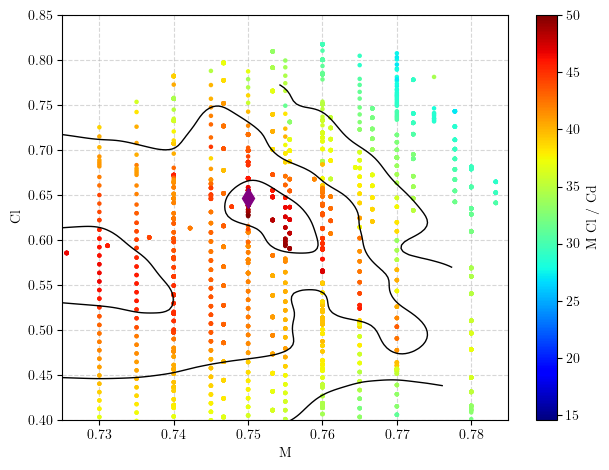

In [12]:


fig, ax = plt.subplots()


Cl_list = []
Cd_list = []
M_list = []
alpha_list = []

for res in App:
    Cl_list.append(res.Cl)
    Cd_list.append(res.Cd)
    M_list.append(res.M)
    alpha_list.append(res.alpha)

buffeting_list = np.nan*np.ones((len(Cl_list), 4))
i = 0
for res in App:
    if len(res.buffet_causes) > 0:
        buffeting_list[i] = res.buffet_causes
    i += 1


Cl_list = np.array(Cl_list)
Cd_list = np.array(Cd_list)
M_list = np.array(M_list)
alpha_list = np.array(alpha_list)

# add them all to the same array to save as csv for jrt66
#data = np.column_stack((M_list, Cl_list, Cd_list, alpha_list, buffeting_list))
#np.savetxt('data.csv', data, delimiter=',', header='M, Cl, Cd, alpha, BF1, BF2, BF3, BF4')

factor = M_list * Cl_list / Cd_list

x_grid, y_grid = np.meshgrid(
        np.linspace(np.min(M_list), np.max(M_list), 200),
        np.linspace(np.min(Cl_list), np.max(Cl_list), 200)
        )

z_grid = griddata((M_list, Cl_list), factor, (x_grid, y_grid), method='linear')
z_grid_smoothed = gaussian_filter(z_grid, sigma=3) 

scat = ax.scatter(M_list, Cl_list, c=factor, s = 5, cmap='jet', zorder = 10)
cont = ax.contour(x_grid, y_grid, z_grid_smoothed, levels=[5, 10, 15, 20, 25, 30, 35, 40, 45], colors='black', linewidths=1, zorder = 20)
# plot operating point as big purple diamond
ax.plot(0.75, 0.64656, 'd', color='purple', markersize=10, zorder = 30)
ax.grid( linestyle='--', alpha=0.5, zorder=1)
# create colourbar
cbar = fig.colorbar(scat, ax=ax)
cbar.set_label("M Cl / Cd")

ax.set_xlim(0.725, 0.785)
ax.set_ylim(0.4, 0.85)

ax.set_xlabel("M")
ax.set_ylabel("Cl")

fig.tight_layout()
# dont overwrite, ive drawn a buffet line on this one
#fig.savefig('figures/performance_metric.png', dpi=400)


